In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Input, Dense
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
mnist_bldr = tfds.builder('fashion_mnist')
mnist_bldr.download_and_prepare()
datasets = mnist_bldr.as_dataset(shuffle_files=False)
print(datasets.keys())
fashion_mnist_train_orig, fashion_mnist_test_orig = datasets['train'], datasets['test']


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteDYL8LD/fashion_mnist-train.tfrecord


  0%|          | 0/60000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteDYL8LD/fashion_mnist-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.
dict_keys(['test', 'train'])


In [10]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
NUM_EPOCHS = 50

In [4]:
fashion_mnist_train = fashion_mnist_train_orig.map(
    lambda item: (tf.cast(item['image'], tf.float32)/255.0, 
                  tf.cast(item['label'], tf.int32)))

fashion_mnist_test = fashion_mnist_test_orig.map(
    lambda item: (tf.cast(item['image'], tf.float32)/255.0, 
                  tf.cast(item['label'], tf.int32)))

tf.random.set_seed(1)

fashion_mnist_train = fashion_mnist_train.shuffle(buffer_size=BUFFER_SIZE,
                                  reshuffle_each_iteration=False)

fashion_mnist_valid = fashion_mnist_train.take(10000).batch(BATCH_SIZE)
fashion_mnist_train = fashion_mnist_train.skip(10000).batch(BATCH_SIZE)

In [9]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(
    filters=32, kernel_size=(5, 5),
    strides=(1, 1), padding='same',
    data_format='channels_last',
    name='conv_1', activation='relu'))

model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), name='pool_1'))
    
model.add(tf.keras.layers.Conv2D(
    filters=64, kernel_size=(5, 5),
    strides=(1, 1), padding='same',
    name='conv_2', activation='relu'))

model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name='pool_2'))

In [11]:
model.compute_output_shape(input_shape=(None, 28, 28, 1))

TensorShape([None, 7, 7, 64])

In [12]:
model.add(tf.keras.layers.Flatten())
    
model.compute_output_shape(input_shape=(None, 28, 28, 1))

TensorShape([None, 3136])

In [13]:
model.add(tf.keras.layers.Dense(
    units=1024, name='fc_1', 
    activation='relu'))

model.add(tf.keras.layers.Dropout(
    rate=0.5))
    
model.add(tf.keras.layers.Dense(
    units=10, name='fc_2',
    activation='softmax'))

In [14]:
tf.random.set_seed(1)
model.build(input_shape=(None, 28, 28, 1))

model.compute_output_shape(input_shape=(None, 28, 28, 1))

TensorShape([None, 10])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 pool_1 (MaxPooling2D)       (None, 14, 14, 32)        0         
                                                                 
 conv_2 (Conv2D)             (None, 14, 14, 64)        51264     
                                                                 
 pool_2 (MaxPooling2D)       (None, 7, 7, 64)          0         
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 fc_1 (Dense)                (None, 1024)              3212288   
                                                                 
 dropout (Dropout)           (None, 1024)              0

In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy']) # same as `tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')`

history = model.fit(fashion_mnist_train, epochs=NUM_EPOCHS, 
                    validation_data=fashion_mnist_valid, 
                    shuffle=True)


Epoch 1/50
782/782 [==============================] - 25s 10ms/step - loss: 0.4430 - accuracy: 0.8388 - val_loss: 0.2951 - val_accuracy: 0.8948
Epoch 2/50
782/782 [==============================] - 6s 7ms/step - loss: 0.2923 - accuracy: 0.8932 - val_loss: 0.2731 - val_accuracy: 0.9031
Epoch 3/50
782/782 [==============================] - 6s 7ms/step - loss: 0.2468 - accuracy: 0.9100 - val_loss: 0.2515 - val_accuracy: 0.9109
Epoch 4/50
782/782 [==============================] - 7s 8ms/step - loss: 0.2156 - accuracy: 0.9196 - val_loss: 0.2319 - val_accuracy: 0.9167
Epoch 5/50
782/782 [==============================] - 6s 7ms/step - loss: 0.1887 - accuracy: 0.9301 - val_loss: 0.2390 - val_accuracy: 0.9151
Epoch 6/50
782/782 [==============================] - 6s 7ms/step - loss: 0.1665 - accuracy: 0.9383 - val_loss: 0.2445 - val_accuracy: 0.9163
Epoch 7/50
782/782 [==============================] - 6s 7ms/step - loss: 0.1471 - accuracy: 0.9456 - val_loss: 0.2619 - val_accuracy: 0.9172
Epoc

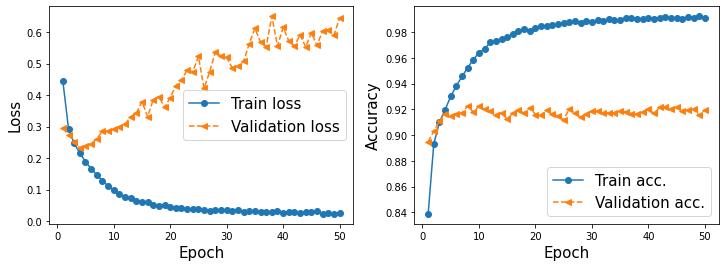

In [17]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

#plt.savefig('figures/15_12.png', dpi=300)
plt.show()

In [20]:
test_results = model.evaluate(fashion_mnist_test.batch(5000))
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

2/2 [==============================] - 1s 36ms/step - loss: 0.7828 - accuracy: 0.9102

Test Acc. 91.02%


TensorShape([12, 10])
tf.Tensor([4 4 9 9 5 1 0 5 7 4 0 8], shape=(12,), dtype=int64)


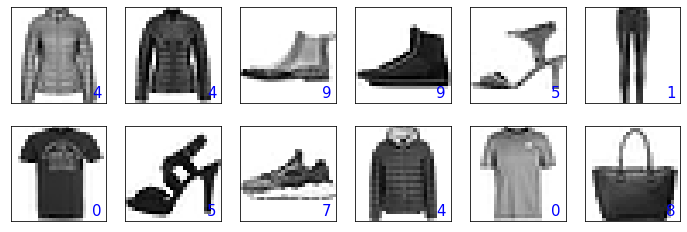

In [21]:
batch_test = next(iter(fashion_mnist_test.batch(12)))

preds = model(batch_test[0])

tf.print(preds.shape)
preds = tf.argmax(preds, axis=1)
print(preds)

fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img = batch_test[0][i, :, :, 0]
    ax.imshow(img, cmap='gray_r')
    ax.text(0.9, 0.1, '{}'.format(preds[i]), 
            size=15, color='blue',
            horizontalalignment='center',
            verticalalignment='center', 
            transform=ax.transAxes)
    
#plt.savefig('figures/15_13.png', dpi=300)
plt.show()

In [22]:
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, Activation, MaxPool2D, GlobalAveragePooling2D, Add
from tensorflow.keras import Model

class ResidualBlock(Model):
    def __init__(self, channel_in = 64, channel_out = 256):
        super().__init__()
        
        channel = channel_out // 4
        
        self.conv1 = Conv2D(channel, kernel_size = (1, 1), padding = "same")
        self.bn1 = BatchNormalization()
        self.av1 = Activation(tf.nn.relu)
        self.conv2 = Conv2D(channel, kernel_size = (3, 3), padding = "same")
        self.bn2 = BatchNormalization()
        self.av2 = Activation(tf.nn.relu)
        self.conv3 = Conv2D(channel_out, kernel_size = (1, 1), padding = "same")
        self.bn3 = BatchNormalization()
        self.shortcut = self._shortcut(channel_in, channel_out)
        self.add = Add()
        self.av3 = Activation(tf.nn.relu)
        
    def call(self, x):
        h = self.conv1(x)
        h = self.bn1(h)
        h = self.av1(h)
        h = self.conv2(h)
        h = self.bn2(h)
        h = self.av2(h)
        h = self.conv3(h)
        h = self.bn3(h)
        shortcut = self.shortcut(x)
        h = self.add([h, shortcut])
        y = self.av3(h)
        return y
    
    def _shortcut(self, channel_in, channel_out):
        if channel_in == channel_out:
            return lambda x : x
        else:
            return self._projection(channel_out)
        
    def _projection(self, channel_out):
        return Conv2D(channel_out, kernel_size = (1, 1), padding = "same")
           
class ResNet50(Model):
    def __init__(self, input_shape, output_dim):
        super().__init__()                
        
        self._layers = [
            # conv1
            Conv2D(64, input_shape = input_shape, kernel_size = (7, 7), strides=(2, 2), padding = "same"),
            BatchNormalization(),
            Activation(tf.nn.relu),
            # conv2_x
            MaxPool2D(pool_size = (3, 3), strides = (2, 2), padding = "same"),
            ResidualBlock(64, 256),
            [
                ResidualBlock(256, 256) for _ in range(2)                
            ],
            # conv3_x
            Conv2D(512, kernel_size = (1, 1), strides=(2, 2)),
            [
                ResidualBlock(512, 512) for _ in range(4)                
            ],
            # conv4_x
            Conv2D(1024, kernel_size = (1, 1), strides=(2, 2)),
            [
                ResidualBlock(1024, 1024) for _ in range(6)                
            ],
            # conv5_x
            Conv2D(2048, kernel_size = (1, 1), strides=(2, 2)),
            [
                ResidualBlock(2048, 2048) for _ in range(3)
            ],
            # last part
            GlobalAveragePooling2D(),
            Dense(1000, activation = tf.nn.relu),
            Dense(output_dim, activation = tf.nn.softmax)
        ]
        
    def call(self, x):
        for layer in self._layers:
            if isinstance(layer, list):
                for l in layer:
                    x = l(x)    
            else:
                x = layer(x)
        return x
       
    
model1 = ResNet50((28, 28, 1), 10)
model1.build(input_shape = (None, 28, 28, 1))
model1.summary()

Model: "res_net50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  3200      
                                                                 
 batch_normalization (BatchN  multiple                 256       
 ormalization)                                                   
                                                                 
 activation (Activation)     multiple                  0         
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 residual_block (ResidualBlo  multiple                 75904     
 ck)                                                             
                                                         

In [23]:
model1.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy']) # same as `tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')`

history = model1.fit(fashion_mnist_train, epochs=NUM_EPOCHS, 
                    validation_data=fashion_mnist_valid, 
                    shuffle=True)


Epoch 1/50
782/782 [==============================] - 44s 49ms/step - loss: 0.7002 - accuracy: 0.7740 - val_loss: 0.4661 - val_accuracy: 0.8314
Epoch 2/50
782/782 [==============================] - 38s 48ms/step - loss: 0.4028 - accuracy: 0.8554 - val_loss: 0.3572 - val_accuracy: 0.8703
Epoch 3/50
782/782 [==============================] - 38s 47ms/step - loss: 0.3389 - accuracy: 0.8783 - val_loss: 0.3895 - val_accuracy: 0.8569
Epoch 4/50
782/782 [==============================] - 38s 47ms/step - loss: 0.3299 - accuracy: 0.8826 - val_loss: 0.3695 - val_accuracy: 0.8703
Epoch 5/50
782/782 [==============================] - 38s 48ms/step - loss: 0.2993 - accuracy: 0.8933 - val_loss: 0.3579 - val_accuracy: 0.8705
Epoch 6/50
782/782 [==============================] - 37s 47ms/step - loss: 0.3379 - accuracy: 0.8828 - val_loss: 0.4085 - val_accuracy: 0.8525
Epoch 7/50
782/782 [==============================] - 38s 47ms/step - loss: 0.3092 - accuracy: 0.8902 - val_loss: 0.3786 - val_accuracy:

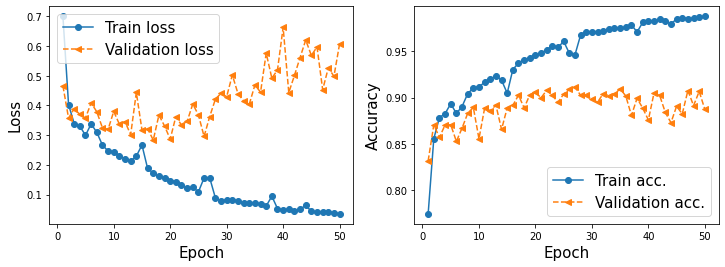

In [24]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

#plt.savefig('figures/15_12.png', dpi=300)
plt.show()

In [26]:
test_results = model1.evaluate(fashion_mnist_test.batch(2000))
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

5/5 [==============================] - 1s 81ms/step - loss: 0.6415 - accuracy: 0.8830

Test Acc. 88.30%


TensorShape([12, 10])
tf.Tensor([6 4 9 7 5 1 0 5 7 4 0 8], shape=(12,), dtype=int64)


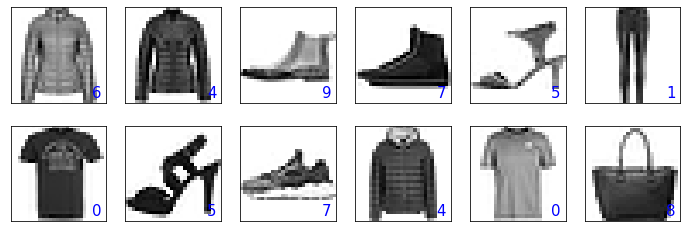

In [27]:
batch_test = next(iter(fashion_mnist_test.batch(12)))

preds = model1(batch_test[0])

tf.print(preds.shape)
preds = tf.argmax(preds, axis=1)
print(preds)

fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img = batch_test[0][i, :, :, 0]
    ax.imshow(img, cmap='gray_r')
    ax.text(0.9, 0.1, '{}'.format(preds[i]), 
            size=15, color='blue',
            horizontalalignment='center',
            verticalalignment='center', 
            transform=ax.transAxes)
    
#plt.savefig('figures/15_13.png', dpi=300)
plt.show()